In [70]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, plot_graphs, plot_mnist
import numpy as np

%matplotlib inline

In [14]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

Device: cuda:0


In [15]:
DATA_PATH = Path('./data/')

In [16]:
mnist_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
           ])
train_loader, valid_loader, test_loader = mnist(valid=10000, transform=mnist_transform, path=DATA_PATH/'MNIST_data')

In [17]:
class Encoder(nn.Module):
    def __init__(self, latent_size=10):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(28*28, latent_size)
    
    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))
        return x
    
class Decoder(nn.Module):
    def __init__(self, latent_size=10):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_size, 28*28)
    
    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        return x

In [18]:
class Net(nn.Module):
    def __init__(self, latent_size=10, loss_fn=F.mse_loss, lr=1e-4, l2=0.):
        super(Net, self).__init__()
        self.latent_size = latent_size
        self.E = Encoder(latent_size)
        self.D = Decoder(latent_size)
        self.loss_fn = loss_fn
        self._rho_loss = None
        self._loss = None
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        h = self.E(x)
        self.data_rho = h.mean(0)
        out = self.D(h)
        return out
    
    def decode(self, h):
        with torch.no_grad():
            return self.D(h)
    
    def rho_loss(self, rho, size_average=True):
        """
        D_KL(P||Q) = sum(p*log(p/q)) = -sum(p*log(q/p)) = -p*log(q/p) - (1-p)log((1-q)/(1-p))
        """
        dkl = - torch.log(self.data_rho/rho) * rho - torch.log((1-self.data_rho)/(1-rho)) * (1-rho)
        if size_average:
            self._rho_loss = dkl.mean()
        else:
            self._rho_loss = dkl.sum()
        return self._rho_loss
    
    def loss(self, x, target, **kwargs):
        target = target.view(-1, 28*28)
        self._loss = self.loss_fn(x, target, **kwargs)
        return self._loss

In [19]:
models = {'16': Net(16).to(device), '32': Net(32).to(device), '64': Net(64).to(device)}
rho = 0.05
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [22]:
def train(epoch, models, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        
        for model in models.values():
            model.optim.zero_grad()
            output = model(data)
            rho_loss = model.rho_loss(rho)
            loss = model.loss(output, data) + rho_loss
            loss.backward()
            model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append((models[k]._loss, models[k]._rho_loss))
        print(line + losses)

In [23]:
avg_lambda = lambda l: 'loss: {:.4f}'.format(l)
rho_lambda = lambda p: 'rho_loss: {:.4f}'.format(p)
line = lambda i, l, p: '{}: '.format(i) + avg_lambda(l) + '\t' + rho_lambda(p)
    
def test(models, loader, log=None):
    test_size = len(loader.sampler)

    test_loss = {k: 0. for k in models}
    rho_loss = {k: 0. for k in models}
    with torch.no_grad():
        for data, _ in loader:
            data = data.to(device)
            output = {k: m(data) for k, m in models.items()}
            
            for k, m in models.items():
                test_loss[k] += m.loss(output[k], data, reduction='sum').item() # sum up batch loss
                rho_loss[k] += m.rho_loss(rho, size_average=False).item()
    
    for k in models:
        test_loss[k] /= (test_size * 784)
        rho_loss[k] /= (test_size * models[k].latent_size)
        if log is not None:
            log[k].append((test_loss[k], rho_loss[k]))
    
    lines = '\n'.join([line(k, test_loss[k], rho_loss[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines        
    print(report)

In [24]:
for epoch in range(1, 21):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, valid_loader, test_log)

Train Epoch: 1 [0/50000 (0%)]	Losses 16: 1.034516 32: 0.989873 64: 1.001368
Train Epoch: 1 [10000/50000 (20%)]	Losses 16: 0.903538 32: 0.859720 64: 0.722455
Train Epoch: 1 [20000/50000 (40%)]	Losses 16: 0.856567 32: 0.669669 64: 0.435733
Train Epoch: 1 [30000/50000 (60%)]	Losses 16: 0.771988 32: 0.511602 64: 0.369679
Train Epoch: 1 [40000/50000 (80%)]	Losses 16: 0.651719 32: 0.429634 64: 0.323986
Train Epoch: 1 [50000/50000 (100%)]	Losses 16: 0.537067 32: 0.362190 64: 0.277579
Test set:
16: loss: 0.5477	rho_loss: 0.0020
32: loss: 0.3737	rho_loss: 0.0024
64: loss: 0.2888	rho_loss: 0.0019

Train Epoch: 2 [0/50000 (0%)]	Losses 16: 0.556217 32: 0.387035 64: 0.304840
Train Epoch: 2 [10000/50000 (20%)]	Losses 16: 0.470057 32: 0.326265 64: 0.251123
Train Epoch: 2 [20000/50000 (40%)]	Losses 16: 0.447084 32: 0.327870 64: 0.259261
Train Epoch: 2 [30000/50000 (60%)]	Losses 16: 0.393922 32: 0.290992 64: 0.227322
Train Epoch: 2 [40000/50000 (80%)]	Losses 16: 0.385804 32: 0.288329 64: 0.227597
Train

In [117]:
normal = torch.distributions.Normal(0.5, 0.1)
norm_mat = normal.sample((64*64,)).view(-1, 64)
norm_mat.shape, norm_mat.min(), norm_mat.max()

(torch.Size([64, 64]), tensor(0.1104), tensor(0.8508))

In [124]:
with torch.no_grad():
    data, _ = next(iter(test_loader))
    print(data.shape)
    data = data.to(device)
    
    # original data
    output = models['64'](data)
    to_plot = output.view(-1, 1, 28, 28).clamp(0, 1).data.cpu().numpy()
    
    # decoded eye matrix
    decoded = models['64'].decode(torch.eye(64).to(device))
    print(decoded.shape)
    dec_to_plot = ((decoded.view(-1, 1, 28, 28) + 1) * 0.5).clamp(0, 1).data.cpu().numpy()
    
    # encoded data with only neurons where activations > 0.5
    encoded = models['64'].E(data.view(-1, 28*28))
    print(encoded.shape)
    print((encoded > 0.5).sum(1))
    encoded[encoded < 0.5] = 0.
    
    # decoded data from previous step
    decoded_f = models['64'].decode(encoded)
    print(decoded_f.shape)
    f_to_plot = ((decoded_f.view(-1, 1, 28, 28) + 1) * 0.5).clamp(0, 1).data.cpu().numpy()

torch.Size([50, 1, 28, 28])
torch.Size([64, 784])
torch.Size([50, 64])
tensor([3, 3, 2, 4, 2, 2, 1, 3, 4, 4, 5, 4, 2, 4, 4, 2, 5, 4, 4, 2, 3, 5, 3, 1,
        1, 5, 3, 3, 4, 3, 2, 4, 4, 3, 3, 3, 2, 3, 2, 2, 3, 3, 2, 1, 2, 3, 3, 1,
        4, 3], device='cuda:0')
torch.Size([50, 784])


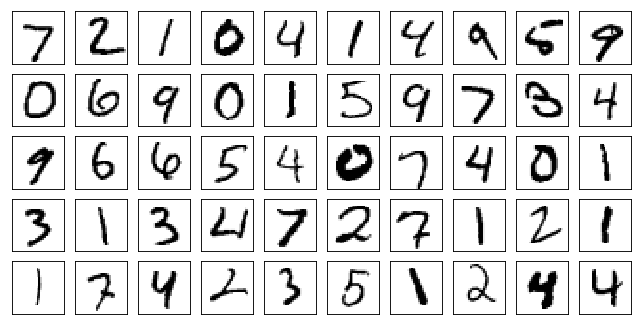

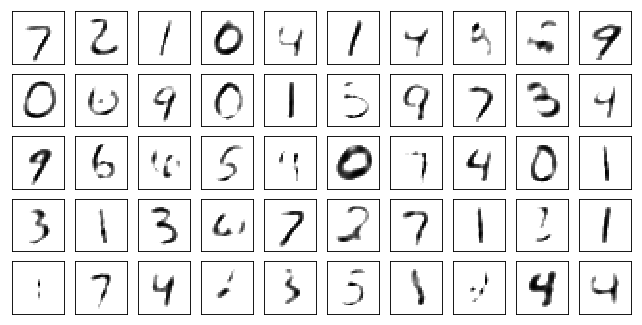

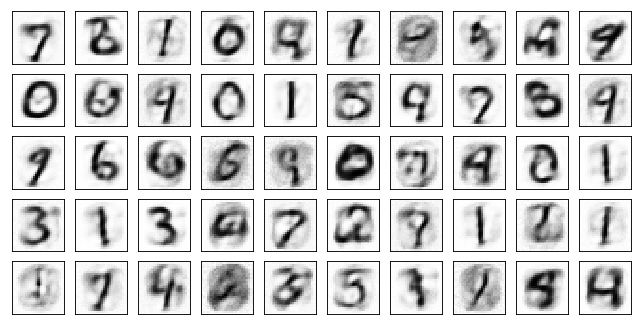

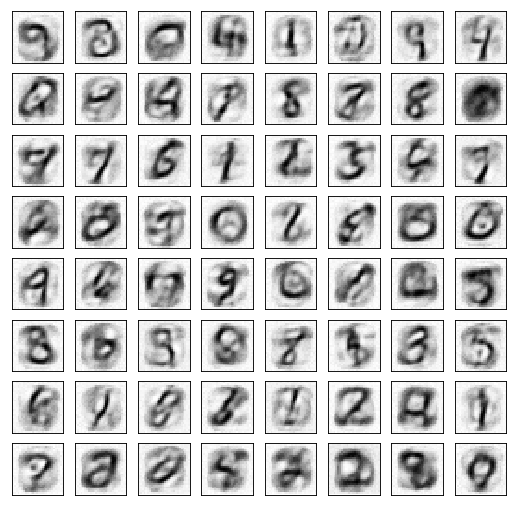

In [125]:
plot_mnist(data.data.cpu().numpy(), (5, 10))
plot_mnist(to_plot, (5, 10))
plot_mnist(f_to_plot, (5, 10))
plot_mnist(dec_to_plot, (8, 8))